# Features engineer

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from dataclasses import dataclass
from typing import List, Dict

# ============================================================
# ⚙️ Normalize utility
# ============================================================
def normalize_array(x: np.ndarray, mode: str = "none", global_mean=None, global_std=None) -> np.ndarray:
    """多模式 normalization"""
    if len(x) == 0:
        return x
    if mode == "none":
        return x
    elif mode == "zscore":
        if global_mean is None or global_std is None:
            raise ValueError("Missing global mean/std for zscore.")
        return (x - global_mean) / (global_std + 1e-8)
    elif mode == "log_zscore":
        x = np.log1p(np.clip(x, a_min=0, a_max=None))
        if global_mean is None or global_std is None:
            global_mean, global_std = np.mean(x), np.std(x)
        return (x - global_mean) / (global_std + 1e-8)
    else:
        raise ValueError(f"Unsupported normalization mode: {mode}")


# ============================================================
# 📏 Helper functions
# ============================================================
@dataclass
class Interval:
    start: int
    end: int

def union_length(intervals: List[Interval]) -> int:
    if not intervals:
        return 0
    intervals.sort(key=lambda iv: (iv.start, iv.end))
    total = 0
    cs, ce = intervals[0].start, intervals[0].end
    for iv in intervals[1:]:
        if iv.start > ce:
            total += ce - cs
            cs, ce = iv.start, iv.end
        elif iv.end > ce:
            ce = iv.end
    total += ce - cs
    return total

def get_tss_region(row, window=1000):
    """根據 strand (+/-) 給出 promoter (TSS ± window) 區域"""
    if row["strand"] == "+":
        start = max(0, row["TSS_start"] - window)
        end = row["TSS_end"]
    else:  # strand == "-"
        start = row["TSS_start"]
        end = row["TSS_end"] + window
    return start, end

def gene_region(row):
    return int(row["gene_start"]), int(row["gene_end"])

def select_mask(peaks_chr: pd.DataFrame, start: int, end: int) -> pd.Series:
    return (peaks_chr["summit"] >= start) & (peaks_chr["summit"] < end)

def shannon_entropy_from_weights(weights: np.ndarray) -> float:
    s = float(weights.sum())
    if s <= 0:
        return 0.0
    p = weights / s
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum()) if p.size else 0.0

def spacing_std_from_positions(pos: np.ndarray) -> float:
    if pos.size < 2:
        return 0.0
    diffs = np.diff(np.sort(pos))
    return float(diffs.std(ddof=0))

# ============================================================
# 🧬 主函式
# ============================================================
def compute_features(df_genes: pd.DataFrame,
                     peaks_by_chr: Dict[str, pd.DataFrame],
                     region: str = "gene",
                     tss_window_bp: int = 5000,
                     norm_mode: str = "none") -> pd.DataFrame:
    assert region in {"gene", "tss"}
    rows = []
    peak_densities = []  # 🆕 收集所有 density

    # === 統一 global mean/std ===
    all_signals = np.concatenate([v["signal_value"].to_numpy() for v in peaks_by_chr.values()])
    global_mean = np.mean(all_signals)
    global_std = np.std(all_signals)
    print(f"🌍 Global mean/std (signal): {global_mean:.4f}, {global_std:.4f}")

    for _, g in tqdm(df_genes.iterrows(), total=len(df_genes), desc=f"Computing {region} features"):
        chrom = g["chr"]
        if chrom not in peaks_by_chr:
            rows.append({"gene_name": g["gene_name"], "has_peak": 0})
            continue

        start, end = (gene_region(g) if region == "gene" else get_tss_region(g, window=tss_window_bp))
        peaks_chr = peaks_by_chr[chrom]
        sub = peaks_chr.loc[select_mask(peaks_chr, start, end)]
        if sub.empty:
            rows.append({"gene_name": g["gene_name"], "has_peak": 0})
            continue

        s_val = sub["signal_value"].to_numpy()
        w = sub["width"].to_numpy()
        qv = sub["q_value"].to_numpy()
        sc = sub["score"].to_numpy()
        summits = sub["summit"].to_numpy()

        # === Normalize signal_value ===
        s_val_norm = normalize_array(s_val, mode=norm_mode, global_mean=global_mean, global_std=global_std)

        region_len = max(1, end - start)
        ivs = [Interval(int(s), int(e)) for s, e in zip(sub["start"], sub["end"])]
        cov = union_length(ivs) / region_len
        n = len(sub)
        peak_density = n / region_len
        peak_densities.append(peak_density)

        # === 統計計算統一函式 ===
        def stat_block(arr):
            if arr.size == 0:
                return dict(sum=0.0, mean=0.0, std=0.0, min=0.0, max=0.0, diff=0.0)
            return dict(
                sum=float(np.sum(arr)),
                mean=float(np.mean(arr)),
                std=float(np.std(arr, ddof=0)),
                min=float(np.min(arr)),
                max=float(np.max(arr)),
                diff=float(np.max(arr) - np.min(arr))
            )

        stat_signal = stat_block(s_val_norm)
        stat_width  = stat_block(w)
        stat_qvalue = stat_block(qv)
        stat_score  = stat_block(sc)

        rows.append({
            "gene_name": g["gene_name"],
            "has_peak": 1,
            "num_peaks": n,
            "peak_density": peak_density,  # 🆕 暫時未 normalize
            **{f"signal_{k}": v for k, v in stat_signal.items()},
            **{f"width_{k}": v for k, v in stat_width.items()},
            **{f"qvalue_{k}": v for k, v in stat_qvalue.items()},
            **{f"score_{k}": v for k, v in stat_score.items()},
            "coverage_ratio": cov,
            "peak_entropy": shannon_entropy_from_weights(s_val_norm),
            "spacing_std": spacing_std_from_positions(summits),
            "width_entropy": float(-np.sum((w / w.sum()) * np.log2((w / w.sum()) + 1e-8))) if w.sum() > 0 else 0.0,
            "compactness": cov / n if n > 0 else 0.0,
            "peak_pos_entropy": (
                lambda hist: float(-np.sum(hist * np.log2(hist + 1e-8)))
            )(np.histogram(np.clip((summits - start) / region_len, 0, 1),
                           bins=5, range=(0, 1))[0] / max(1, n))
            if region_len > 0 and len(summits) > 0 else 0.0,
            "closest_peak_to_TSS": float(np.abs(summits - ((g["TSS_start"] + g["TSS_end"]) / 2)).min()),
            "directional_peak_bias": (
                (np.sum(summits > ((g["TSS_start"] + g["TSS_end"]) / 2)) -
                 np.sum(summits < ((g["TSS_start"] + g["TSS_end"]) / 2))) / n if n > 0 else 0.0
            ),
            "signal_weighted_dist_to_TSS": (
                float(np.sum(s_val_norm * np.abs(summits - ((g["TSS_start"] + g["TSS_end"]) / 2)))) / np.sum(s_val_norm)
                if np.sum(s_val_norm) > 0 else 0.0
            ),
        })

    # === 組裝結果表 ===
    df = pd.DataFrame(rows)

    # === 🧮 peak_density 做 0–1 normalization ===
    if "peak_density" in df.columns:
        min_d, max_d = np.nanmin(peak_densities), np.nanmax(peak_densities)
        if max_d > min_d:
            df["peak_density"] = (df["peak_density"] - min_d) / (max_d - min_d)
        else:
            df["peak_density"] = 0.0

    # === 🧹 把所有 NaN 補 0 ===
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0.0)
    df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)

    return df


In [ ]:
# ============================================================
#                  基本設定
# ============================================================
REF_PATH = "../preprocessed_data/reference/reference_gene_table.tsv"
PEAK_FILE = "../ML4G_Project_1_Data/H3K4me1-bed/X2.bed"
OUTPUT_PATH = "../preprocessed_data/reference/0. raw_bed/X2_raw_bed_fullFeatures.tsv"

TSS_WINDOW_BP = 5000
MARK_NAME = "H3K4me1"

# ============================================================
#                  載入資料
# ============================================================
ref_genes = pd.read_csv(REF_PATH, sep="\t")
print(f"📖 Loaded reference table: {REF_PATH} ({len(ref_genes)} genes)")

df_peaks = pd.read_csv(
    PEAK_FILE, sep="\t", header=None,
    names=["chr", "start", "end", "name", "score", "strand", "signal_value", "p_value", "q_value", "peak"],
    dtype={"chr": str, "start": np.int64, "end": np.int64, "name": str, "score": float,
           "strand": str, "signal_value": float, "p_value": float, "q_value": float, "peak": np.int64}
)
print(f"📂 Loaded {len(df_peaks)} peaks from {PEAK_FILE}")

df_peaks["summit"] = df_peaks["start"] + df_peaks["peak"]
df_peaks["width"] = df_peaks["end"] - df_peaks["start"]
peaks_by_chr: Dict[str, pd.DataFrame] = {c: sub.reset_index(drop=True) for c, sub in df_peaks.groupby("chr", sort=False)}


feat_gene = compute_features(ref_genes, peaks_by_chr, region="gene", norm_mode="log_zscore")
feat_tss  = compute_features(ref_genes, peaks_by_chr, region="tss", norm_mode="log_zscore")

# 加上標籤方便 merge
feat_gene = feat_gene.rename(columns={c: f"{MARK_NAME}_gene_{c}" for c in feat_gene.columns if c != "gene_name"})
feat_tss  = feat_tss.rename(columns={c: f"{MARK_NAME}_tss_{c}" for c in feat_tss.columns if c != "gene_name"})

df_out = (ref_genes[["gene_name"]]
          .merge(feat_gene, on="gene_name", how="left")
          .merge(feat_tss,  on="gene_name", how="left"))
df_out = df_out.fillna(0.0)

📖 Loaded reference table: ../preprocessed_data/reference/reference_gene_table.tsv (18268 genes)
📂 Loaded 135476 peaks from ../ML4G_Project_1_Data/H3K4me1-bed/X2.bed
🌍 Global mean/std (signal): 4.1086, 1.0515


Computing gene features: 100%|██████████| 18268/18268 [00:08<00:00, 2246.50it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_65120/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1086, 1.0515


Computing tss features: 100%|██████████| 18268/18268 [00:06<00:00, 2884.81it/s]


In [ ]:
import os
import numpy as np
import pandas as pd
from typing import List

# ============================================================
#                  批次整合多 mark / 多 cell line
# ============================================================
def process_cellline(cell_name: str,
                     marks: List[str],
                     base_dir: str,
                     ref_path: str,
                     tss_window_bp: int = 5000,
                     output_dir: str = "../preprocessed_data/reference/0. raw_bed",
                     norm_mode: str = "log_zscore"):
    """
    對指定 cell line (如 X1) 的所有 histone marks 一次處理。
    使用 reference_gene_table.tsv 為基準。
    支援 normalization 模式 (none / zscore / log_zscore)
    """
    print(f"\n=== 🧬 Processing Cell Line: {cell_name} ===")
    print(f"Normalization mode: {norm_mode}")

    # --- 載入 reference ---
    df_genes = pd.read_csv(ref_path, sep="\t")
    print(f"📖 Loaded reference table: {len(df_genes)} genes")

    # --- 基礎表格 ---
    df_all = df_genes[["gene_name", "chr", "strand", "gene_start", "gene_end", "TSS_start", "TSS_end"]].copy()

    # --- 每個 mark 處理 ---
    for mark in marks:
        bed_path = os.path.join(base_dir, f"{mark}-bed", f"{cell_name}.bed")
        if not os.path.exists(bed_path):
            print(f"⚠️ Missing {mark} for {cell_name}: {bed_path}")
            continue

        print(f"\n📘 Reading {mark} ({cell_name}) ...")
        df_peaks = pd.read_csv(
            bed_path, sep="\t", header=None,
            names=["chr", "start", "end", "name", "score", "strand",
                   "signal_value", "p_value", "q_value", "peak"],
            dtype={"chr": str, "start": np.int64, "end": np.int64,
                   "name": str, "score": float, "strand": str,
                   "signal_value": float, "p_value": float,
                   "q_value": float, "peak": np.int64}
        )

        # === 基本欄位處理 ===
        df_peaks["summit"] = df_peaks["start"] + df_peaks["peak"]
        df_peaks["width"] = df_peaks["end"] - df_peaks["start"]
        peaks_by_chr = {c: sub.reset_index(drop=True) for c, sub in df_peaks.groupby("chr", sort=False)}
        print(f"📊 Loaded {len(df_peaks)} peaks, grouped into {len(peaks_by_chr)} chromosomes")

        # === 計算特徵 ===
        print(f"⚙️ Computing features for {mark} ({cell_name}) ...")
        feat_gene = compute_features(df_genes, peaks_by_chr, region="gene", tss_window_bp=tss_window_bp, norm_mode=norm_mode)
        feat_tss  = compute_features(df_genes, peaks_by_chr, region="tss",  tss_window_bp=tss_window_bp, norm_mode=norm_mode)

        # === 加上前綴標籤 ===
        feat_gene = feat_gene.rename(columns={c: f"{mark}_gene_{c}" for c in feat_gene.columns if c != "gene_name"})
        feat_tss  = feat_tss.rename(columns={c: f"{mark}_tss_{c}"  for c in feat_tss.columns if c != "gene_name"})

        # === 合併進主表 ===
        df_all = df_all.merge(feat_gene, on="gene_name", how="left")
        df_all = df_all.merge(feat_tss,  on="gene_name", how="left")

    # === 補 0 ===
    df_all = df_all.fillna(0.0)

    # === 動態輸出檔名 ===
    norm_suffix = {
        "none": "raw",
        "zscore": "zscore",
        "log_zscore": "logzscore"
    }.get(norm_mode, norm_mode)

    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, f"{cell_name}_{norm_suffix}.tsv")
    df_all.to_csv(out_path, sep="\t", index=False)

    print(f"\n✅ Saved: {out_path}")
    print(f"📊 Final shape: {df_all.shape[0]} genes × {df_all.shape[1]} columns")
    return df_all




In [6]:
# ============================================================
#                  主批次執行
# ============================================================
if __name__ == "__main__":
    base_dir = "/Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data"
    ref_path = "../preprocessed_data/reference/reference_gene_table.tsv"
    output_dir = "../preprocessed_data/reference/0. data/bed250_one_side/"

    marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
    cells = ["X1", "X2", "X3"]

    for cell in cells:
        process_cellline(
            cell_name=cell,
            marks=marks,
            base_dir=base_dir,
            ref_path=ref_path,
            tss_window_bp=250,
            output_dir=output_dir,
            norm_mode="log_zscore"  # 🔧 可改成 none / zscore
        )


=== 🧬 Processing Cell Line: X1 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X1) ...
📊 Loaded 56452 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X1) ...
🌍 Global mean/std (signal): 41.9516, 69.8208


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2565.39it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 41.9516, 69.8208


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 3859.00it/s]



📘 Reading H3K27ac (X1) ...
📊 Loaded 57887 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K27ac (X1) ...
🌍 Global mean/std (signal): 10.4143, 8.9643


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3072.20it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.4143, 8.9643


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5495.03it/s]



📘 Reading H3K4me3 (X1) ...
📊 Loaded 42002 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K4me3 (X1) ...
🌍 Global mean/std (signal): 8.1494, 4.5913


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2941.71it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 8.1494, 4.5913


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5085.79it/s]



📘 Reading H3K27me3 (X1) ...
📊 Loaded 26900 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K27me3 (X1) ...
🌍 Global mean/std (signal): 35.4562, 7.7610


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4200.86it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 35.4562, 7.7610


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6213.80it/s]



📘 Reading H3K36me3 (X1) ...
📊 Loaded 81541 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K36me3 (X1) ...
🌍 Global mean/std (signal): 6.3442, 1.7012


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3178.66it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 6.3442, 1.7012


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5940.80it/s]



📘 Reading H3K4me1 (X1) ...
📊 Loaded 89812 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me1 (X1) ...
🌍 Global mean/std (signal): 4.7735, 1.7659


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2669.85it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.7735, 1.7659


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6600.52it/s]



📘 Reading H3K9me3 (X1) ...
📊 Loaded 18835 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K9me3 (X1) ...
🌍 Global mean/std (signal): 4.1487, 0.9139


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4317.15it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1487, 0.9139


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6673.42it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed250_one_side/X1_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X2 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X2) ...
📊 Loaded 181146 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X2) ...
🌍 Global mean/std (signal): 92.3270, 122.1105


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2293.93it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 92.3270, 122.1105


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3239.25it/s]



📘 Reading H3K27ac (X2) ...
📊 Loaded 76094 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K27ac (X2) ...
🌍 Global mean/std (signal): 27.9351, 15.7785


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3053.78it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 27.9351, 15.7785


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5336.09it/s]



📘 Reading H3K4me3 (X2) ...
📊 Loaded 42142 peaks, grouped into 39 chromosomes
⚙️ Computing features for H3K4me3 (X2) ...
🌍 Global mean/std (signal): 2.3985, 2.0274


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2497.81it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.3985, 2.0274


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5289.15it/s]



📘 Reading H3K27me3 (X2) ...
📊 Loaded 24458 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27me3 (X2) ...
🌍 Global mean/std (signal): 3.7757, 3.3489


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 3972.65it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7757, 3.3489


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6132.63it/s]



📘 Reading H3K36me3 (X2) ...
📊 Loaded 77131 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K36me3 (X2) ...
🌍 Global mean/std (signal): 4.0910, 1.0740


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3166.36it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.0910, 1.0740


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6306.91it/s]



📘 Reading H3K4me1 (X2) ...
📊 Loaded 135476 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X2) ...
🌍 Global mean/std (signal): 4.1086, 1.0515


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2662.58it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1086, 1.0515


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5839.76it/s]



📘 Reading H3K9me3 (X2) ...
📊 Loaded 94156 peaks, grouped into 91 chromosomes
⚙️ Computing features for H3K9me3 (X2) ...
🌍 Global mean/std (signal): 4.6121, 1.2591


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4077.67it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.6121, 1.2591


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6813.89it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed250_one_side/X2_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X3 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X3) ...
📊 Loaded 71812 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X3) ...
🌍 Global mean/std (signal): 49.7253, 41.5291


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2399.71it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 49.7253, 41.5291


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3110.99it/s]



📘 Reading H3K27ac (X3) ...
📊 Loaded 54474 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27ac (X3) ...
🌍 Global mean/std (signal): 10.1940, 8.4926


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2751.32it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.1940, 8.4926


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 4784.57it/s]



📘 Reading H3K4me3 (X3) ...
📊 Loaded 34488 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me3 (X3) ...
🌍 Global mean/std (signal): 13.2355, 11.7258


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2645.05it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 13.2355, 11.7258


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5666.86it/s]



📘 Reading H3K27me3 (X3) ...
📊 Loaded 82769 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K27me3 (X3) ...
🌍 Global mean/std (signal): 4.9255, 1.9164


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 3977.34it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.9255, 1.9164


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6148.51it/s]



📘 Reading H3K36me3 (X3) ...
📊 Loaded 68682 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K36me3 (X3) ...
🌍 Global mean/std (signal): 4.8880, 1.2712


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3282.73it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.8880, 1.2712


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 6085.76it/s]



📘 Reading H3K4me1 (X3) ...
📊 Loaded 107213 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X3) ...
🌍 Global mean/std (signal): 2.7148, 1.0648


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2474.81it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.7148, 1.0648


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5862.17it/s]



📘 Reading H3K9me3 (X3) ...
📊 Loaded 46565 peaks, grouped into 69 chromosomes
⚙️ Computing features for H3K9me3 (X3) ...
🌍 Global mean/std (signal): 3.7462, 0.6023


Computing gene features: 100%|██████████| 18268/18268 [00:03<00:00, 5515.05it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7462, 0.6023


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6273.14it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed250_one_side/X3_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns


In [10]:
# ============================================================
#                  主批次執行
# ============================================================
if __name__ == "__main__":
    base_dir = "/Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data"
    ref_path = "../preprocessed_data/reference/reference_gene_table.tsv"
    output_dir = "../preprocessed_data/reference/0. data/bed50_one_side"

    marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
    cells = ["X1", "X2", "X3"]

    for cell in cells:
        process_cellline(
            cell_name=cell,
            marks=marks,
            base_dir=base_dir,
            ref_path=ref_path,
            tss_window_bp=50,
            output_dir=output_dir,
            norm_mode="log_zscore"  # 🔧 可改成 none / zscore
        )


=== 🧬 Processing Cell Line: X1 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X1) ...
📊 Loaded 56452 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X1) ...
🌍 Global mean/std (signal): 41.9516, 69.8208


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2613.54it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 41.9516, 69.8208


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4400.27it/s]



📘 Reading H3K27ac (X1) ...
📊 Loaded 57887 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K27ac (X1) ...
🌍 Global mean/std (signal): 10.4143, 8.9643


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2711.19it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.4143, 8.9643


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6784.77it/s]



📘 Reading H3K4me3 (X1) ...
📊 Loaded 42002 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K4me3 (X1) ...
🌍 Global mean/std (signal): 8.1494, 4.5913


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2764.68it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 8.1494, 4.5913


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6201.01it/s]



📘 Reading H3K27me3 (X1) ...
📊 Loaded 26900 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K27me3 (X1) ...
🌍 Global mean/std (signal): 35.4562, 7.7610


Computing gene features: 100%|██████████| 18268/18268 [00:03<00:00, 4683.03it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 35.4562, 7.7610


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6466.83it/s]



📘 Reading H3K36me3 (X1) ...
📊 Loaded 81541 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K36me3 (X1) ...
🌍 Global mean/std (signal): 6.3442, 1.7012


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2956.00it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 6.3442, 1.7012


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6769.47it/s]



📘 Reading H3K4me1 (X1) ...
📊 Loaded 89812 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me1 (X1) ...
🌍 Global mean/std (signal): 4.7735, 1.7659


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2906.89it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.7735, 1.7659


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6325.67it/s]



📘 Reading H3K9me3 (X1) ...
📊 Loaded 18835 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K9me3 (X1) ...
🌍 Global mean/std (signal): 4.1487, 0.9139


Computing gene features: 100%|██████████| 18268/18268 [00:03<00:00, 4796.13it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1487, 0.9139


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7107.32it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed50_one_side/X1_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X2 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X2) ...
📊 Loaded 181146 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X2) ...
🌍 Global mean/std (signal): 92.3270, 122.1105


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2566.28it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 92.3270, 122.1105


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 4741.88it/s]



📘 Reading H3K27ac (X2) ...
📊 Loaded 76094 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K27ac (X2) ...
🌍 Global mean/std (signal): 27.9351, 15.7785


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3183.26it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 27.9351, 15.7785


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6376.90it/s]



📘 Reading H3K4me3 (X2) ...
📊 Loaded 42142 peaks, grouped into 39 chromosomes
⚙️ Computing features for H3K4me3 (X2) ...
🌍 Global mean/std (signal): 2.3985, 2.0274


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2799.34it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.3985, 2.0274


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6787.99it/s]



📘 Reading H3K27me3 (X2) ...
📊 Loaded 24458 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27me3 (X2) ...
🌍 Global mean/std (signal): 3.7757, 3.3489


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 3918.11it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7757, 3.3489


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6857.38it/s]



📘 Reading H3K36me3 (X2) ...
📊 Loaded 77131 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K36me3 (X2) ...
🌍 Global mean/std (signal): 4.0910, 1.0740


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3365.79it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.0910, 1.0740


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7098.16it/s]



📘 Reading H3K4me1 (X2) ...
📊 Loaded 135476 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X2) ...
🌍 Global mean/std (signal): 4.1086, 1.0515


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2820.49it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1086, 1.0515


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7009.77it/s]



📘 Reading H3K9me3 (X2) ...
📊 Loaded 94156 peaks, grouped into 91 chromosomes
⚙️ Computing features for H3K9me3 (X2) ...
🌍 Global mean/std (signal): 4.6121, 1.2591


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4452.19it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.6121, 1.2591


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7250.92it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed50_one_side/X2_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X3 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X3) ...
📊 Loaded 71812 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X3) ...
🌍 Global mean/std (signal): 49.7253, 41.5291


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2970.41it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 49.7253, 41.5291


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 4901.90it/s]



📘 Reading H3K27ac (X3) ...
📊 Loaded 54474 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27ac (X3) ...
🌍 Global mean/std (signal): 10.1940, 8.4926


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3193.24it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.1940, 8.4926


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6785.73it/s]



📘 Reading H3K4me3 (X3) ...
📊 Loaded 34488 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me3 (X3) ...
🌍 Global mean/std (signal): 13.2355, 11.7258


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2632.54it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 13.2355, 11.7258


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 6027.51it/s]



📘 Reading H3K27me3 (X3) ...
📊 Loaded 82769 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K27me3 (X3) ...
🌍 Global mean/std (signal): 4.9255, 1.9164


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 3732.97it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.9255, 1.9164


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6267.63it/s]



📘 Reading H3K36me3 (X3) ...
📊 Loaded 68682 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K36me3 (X3) ...
🌍 Global mean/std (signal): 4.8880, 1.2712


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2794.27it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.8880, 1.2712


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6265.66it/s]



📘 Reading H3K4me1 (X3) ...
📊 Loaded 107213 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X3) ...
🌍 Global mean/std (signal): 2.7148, 1.0648


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2491.08it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.7148, 1.0648


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6876.08it/s]



📘 Reading H3K9me3 (X3) ...
📊 Loaded 46565 peaks, grouped into 69 chromosomes
⚙️ Computing features for H3K9me3 (X3) ...
🌍 Global mean/std (signal): 3.7462, 0.6023


Computing gene features: 100%|██████████| 18268/18268 [00:03<00:00, 5325.69it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7462, 0.6023


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6510.39it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed50_one_side/X3_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns


In [11]:
# ============================================================
#                  主批次執行
# ============================================================
if __name__ == "__main__":
    base_dir = "/Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data"
    ref_path = "../preprocessed_data/reference/reference_gene_table.tsv"
    output_dir = "../preprocessed_data/reference/0. data/bed0_one_side"

    marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
    cells = ["X1", "X2", "X3"]

    for cell in cells:
        process_cellline(
            cell_name=cell,
            marks=marks,
            base_dir=base_dir,
            ref_path=ref_path,
            tss_window_bp=0,
            output_dir=output_dir,
            norm_mode="log_zscore"  # 🔧 可改成 none / zscore
        )


=== 🧬 Processing Cell Line: X1 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X1) ...
📊 Loaded 56452 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X1) ...
🌍 Global mean/std (signal): 41.9516, 69.8208


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2422.61it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 41.9516, 69.8208


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4484.32it/s]



📘 Reading H3K27ac (X1) ...
📊 Loaded 57887 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K27ac (X1) ...
🌍 Global mean/std (signal): 10.4143, 8.9643


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2389.72it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.4143, 8.9643


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5688.43it/s]



📘 Reading H3K4me3 (X1) ...
📊 Loaded 42002 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K4me3 (X1) ...
🌍 Global mean/std (signal): 8.1494, 4.5913


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2362.52it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 8.1494, 4.5913


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5565.26it/s]



📘 Reading H3K27me3 (X1) ...
📊 Loaded 26900 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K27me3 (X1) ...
🌍 Global mean/std (signal): 35.4562, 7.7610


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3451.08it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 35.4562, 7.7610


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5697.64it/s]



📘 Reading H3K36me3 (X1) ...
📊 Loaded 81541 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K36me3 (X1) ...
🌍 Global mean/std (signal): 6.3442, 1.7012


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2724.49it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 6.3442, 1.7012


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5815.47it/s]



📘 Reading H3K4me1 (X1) ...
📊 Loaded 89812 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me1 (X1) ...
🌍 Global mean/std (signal): 4.7735, 1.7659


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2753.11it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.7735, 1.7659


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6127.95it/s]



📘 Reading H3K9me3 (X1) ...
📊 Loaded 18835 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K9me3 (X1) ...
🌍 Global mean/std (signal): 4.1487, 0.9139


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3597.85it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1487, 0.9139


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5904.72it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed0_one_side/X1_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X2 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X2) ...
📊 Loaded 181146 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X2) ...
🌍 Global mean/std (signal): 92.3270, 122.1105


Computing gene features: 100%|██████████| 18268/18268 [00:08<00:00, 2177.41it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 92.3270, 122.1105


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5315.97it/s]



📘 Reading H3K27ac (X2) ...
📊 Loaded 76094 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K27ac (X2) ...
🌍 Global mean/std (signal): 27.9351, 15.7785


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2313.58it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 27.9351, 15.7785


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5746.02it/s]



📘 Reading H3K4me3 (X2) ...
📊 Loaded 42142 peaks, grouped into 39 chromosomes
⚙️ Computing features for H3K4me3 (X2) ...
🌍 Global mean/std (signal): 2.3985, 2.0274


Computing gene features: 100%|██████████| 18268/18268 [00:08<00:00, 2176.97it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.3985, 2.0274


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5866.05it/s]



📘 Reading H3K27me3 (X2) ...
📊 Loaded 24458 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27me3 (X2) ...
🌍 Global mean/std (signal): 3.7757, 3.3489


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 3762.68it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7757, 3.3489


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 6002.28it/s]



📘 Reading H3K36me3 (X2) ...
📊 Loaded 77131 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K36me3 (X2) ...
🌍 Global mean/std (signal): 4.0910, 1.0740


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2643.30it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.0910, 1.0740


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5227.78it/s]



📘 Reading H3K4me1 (X2) ...
📊 Loaded 135476 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X2) ...
🌍 Global mean/std (signal): 4.1086, 1.0515


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2366.07it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1086, 1.0515


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5944.50it/s]



📘 Reading H3K9me3 (X2) ...
📊 Loaded 94156 peaks, grouped into 91 chromosomes
⚙️ Computing features for H3K9me3 (X2) ...
🌍 Global mean/std (signal): 4.6121, 1.2591


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4455.68it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.6121, 1.2591


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7320.60it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed0_one_side/X2_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X3 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X3) ...
📊 Loaded 71812 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X3) ...
🌍 Global mean/std (signal): 49.7253, 41.5291


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2944.58it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 49.7253, 41.5291


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6409.91it/s]



📘 Reading H3K27ac (X3) ...
📊 Loaded 54474 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27ac (X3) ...
🌍 Global mean/std (signal): 10.1940, 8.4926


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3332.26it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.1940, 8.4926


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7070.21it/s]



📘 Reading H3K4me3 (X3) ...
📊 Loaded 34488 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me3 (X3) ...
🌍 Global mean/std (signal): 13.2355, 11.7258


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2953.30it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 13.2355, 11.7258


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5366.16it/s]



📘 Reading H3K27me3 (X3) ...
📊 Loaded 82769 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K27me3 (X3) ...
🌍 Global mean/std (signal): 4.9255, 1.9164


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4347.49it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.9255, 1.9164


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7031.52it/s]



📘 Reading H3K36me3 (X3) ...
📊 Loaded 68682 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K36me3 (X3) ...
🌍 Global mean/std (signal): 4.8880, 1.2712


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 3718.95it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.8880, 1.2712


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6851.09it/s]



📘 Reading H3K4me1 (X3) ...
📊 Loaded 107213 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X3) ...
🌍 Global mean/std (signal): 2.7148, 1.0648


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2893.63it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.7148, 1.0648


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7011.98it/s]



📘 Reading H3K9me3 (X3) ...
📊 Loaded 46565 peaks, grouped into 69 chromosomes
⚙️ Computing features for H3K9me3 (X3) ...
🌍 Global mean/std (signal): 3.7462, 0.6023


Computing gene features: 100%|██████████| 18268/18268 [00:02<00:00, 6093.17it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74264/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7462, 0.6023


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 7352.05it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed0_one_side/X3_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns


In [12]:
if __name__ == "__main__":
    base_dir = "/Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data"
    ref_path = "../preprocessed_data/reference/reference_gene_table.tsv"
    output_dir = "../preprocessed_data/reference/0. data/bed500_one_side"

    marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
    cells = ["X1", "X2", "X3"]

    for cell in cells:
        process_cellline(
            cell_name=cell,
            marks=marks,
            base_dir=base_dir,
            ref_path=ref_path,
            tss_window_bp=500,
            output_dir=output_dir,
            norm_mode="log_zscore"  # 🔧 可改成 none / zscore
        )


=== 🧬 Processing Cell Line: X1 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X1) ...
📊 Loaded 56452 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X1) ...
🌍 Global mean/std (signal): 41.9516, 69.8208


Computing gene features: 100%|██████████| 18268/18268 [00:09<00:00, 2005.16it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 41.9516, 69.8208


Computing tss features: 100%|██████████| 18268/18268 [00:06<00:00, 2786.06it/s]



📘 Reading H3K27ac (X1) ...
📊 Loaded 57887 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K27ac (X1) ...
🌍 Global mean/std (signal): 10.4143, 8.9643


Computing gene features: 100%|██████████| 18268/18268 [00:08<00:00, 2120.52it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.4143, 8.9643


Computing tss features: 100%|██████████| 18268/18268 [00:06<00:00, 2916.86it/s]



📘 Reading H3K4me3 (X1) ...
📊 Loaded 42002 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K4me3 (X1) ...
🌍 Global mean/std (signal): 8.1494, 4.5913


Computing gene features: 100%|██████████| 18268/18268 [00:09<00:00, 2000.77it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 8.1494, 4.5913


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 3665.04it/s]



📘 Reading H3K27me3 (X1) ...
📊 Loaded 26900 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K27me3 (X1) ...
🌍 Global mean/std (signal): 35.4562, 7.7610


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3372.56it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 35.4562, 7.7610


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4344.64it/s]



📘 Reading H3K36me3 (X1) ...
📊 Loaded 81541 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K36me3 (X1) ...
🌍 Global mean/std (signal): 6.3442, 1.7012


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2522.54it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 6.3442, 1.7012


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4518.16it/s]



📘 Reading H3K4me1 (X1) ...
📊 Loaded 89812 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me1 (X1) ...
🌍 Global mean/std (signal): 4.7735, 1.7659


Computing gene features: 100%|██████████| 18268/18268 [00:08<00:00, 2195.23it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.7735, 1.7659


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4181.21it/s]



📘 Reading H3K9me3 (X1) ...
📊 Loaded 18835 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K9me3 (X1) ...
🌍 Global mean/std (signal): 4.1487, 0.9139


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3454.95it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1487, 0.9139


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 4808.86it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed500_one_side/X1_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X2 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X2) ...
📊 Loaded 181146 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X2) ...
🌍 Global mean/std (signal): 92.3270, 122.1105


Computing gene features: 100%|██████████| 18268/18268 [00:09<00:00, 1905.81it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 92.3270, 122.1105


Computing tss features: 100%|██████████| 18268/18268 [00:07<00:00, 2317.92it/s]



📘 Reading H3K27ac (X2) ...
📊 Loaded 76094 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K27ac (X2) ...
🌍 Global mean/std (signal): 27.9351, 15.7785


Computing gene features: 100%|██████████| 18268/18268 [00:09<00:00, 2026.72it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 27.9351, 15.7785


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3430.69it/s]



📘 Reading H3K4me3 (X2) ...
📊 Loaded 42142 peaks, grouped into 39 chromosomes
⚙️ Computing features for H3K4me3 (X2) ...
🌍 Global mean/std (signal): 2.3985, 2.0274


Computing gene features: 100%|██████████| 18268/18268 [00:09<00:00, 2003.92it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.3985, 2.0274


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3146.10it/s]



📘 Reading H3K27me3 (X2) ...
📊 Loaded 24458 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27me3 (X2) ...
🌍 Global mean/std (signal): 3.7757, 3.3489


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3083.46it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7757, 3.3489


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5045.50it/s]



📘 Reading H3K36me3 (X2) ...
📊 Loaded 77131 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K36me3 (X2) ...
🌍 Global mean/std (signal): 4.0910, 1.0740


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2693.09it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.0910, 1.0740


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5208.54it/s]



📘 Reading H3K4me1 (X2) ...
📊 Loaded 135476 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X2) ...
🌍 Global mean/std (signal): 4.1086, 1.0515


Computing gene features: 100%|██████████| 18268/18268 [00:08<00:00, 2114.94it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1086, 1.0515


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4281.52it/s]



📘 Reading H3K9me3 (X2) ...
📊 Loaded 94156 peaks, grouped into 91 chromosomes
⚙️ Computing features for H3K9me3 (X2) ...
🌍 Global mean/std (signal): 4.6121, 1.2591


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3296.76it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.6121, 1.2591


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5331.56it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed500_one_side/X2_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X3 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X3) ...
📊 Loaded 71812 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X3) ...
🌍 Global mean/std (signal): 49.7253, 41.5291


Computing gene features: 100%|██████████| 18268/18268 [00:10<00:00, 1721.31it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 49.7253, 41.5291


Computing tss features: 100%|██████████| 18268/18268 [00:07<00:00, 2344.13it/s]



📘 Reading H3K27ac (X3) ...
📊 Loaded 54474 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27ac (X3) ...
🌍 Global mean/std (signal): 10.1940, 8.4926


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2467.50it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.1940, 8.4926


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4029.56it/s]



📘 Reading H3K4me3 (X3) ...
📊 Loaded 34488 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me3 (X3) ...
🌍 Global mean/std (signal): 13.2355, 11.7258


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2302.52it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 13.2355, 11.7258


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4085.96it/s]



📘 Reading H3K27me3 (X3) ...
📊 Loaded 82769 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K27me3 (X3) ...
🌍 Global mean/std (signal): 4.9255, 1.9164


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3510.77it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.9255, 1.9164


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5169.20it/s]



📘 Reading H3K36me3 (X3) ...
📊 Loaded 68682 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K36me3 (X3) ...
🌍 Global mean/std (signal): 4.8880, 1.2712


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2649.57it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.8880, 1.2712


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5154.19it/s]



📘 Reading H3K4me1 (X3) ...
📊 Loaded 107213 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X3) ...
🌍 Global mean/std (signal): 2.7148, 1.0648


Computing gene features: 100%|██████████| 18268/18268 [00:10<00:00, 1710.70it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.7148, 1.0648


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4116.72it/s]



📘 Reading H3K9me3 (X3) ...
📊 Loaded 46565 peaks, grouped into 69 chromosomes
⚙️ Computing features for H3K9me3 (X3) ...
🌍 Global mean/std (signal): 3.7462, 0.6023


Computing gene features: 100%|██████████| 18268/18268 [00:03<00:00, 4795.98it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/3463236200.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7462, 0.6023


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5182.11it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed500_one_side/X3_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns


In [7]:
if __name__ == "__main__":
    base_dir = "/Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data"
    ref_path = "../preprocessed_data/reference/reference_gene_table.tsv"
    output_dir = "../preprocessed_data/reference/0. data/bed3000"

    marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
    cells = ["X1", "X2", "X3"]

    for cell in cells:
        process_cellline(
            cell_name=cell,
            marks=marks,
            base_dir=base_dir,
            ref_path=ref_path,
            tss_window_bp=3000,
            output_dir=output_dir,
            norm_mode="log_zscore"  # 🔧 可改成 none / zscore
        )


=== 🧬 Processing Cell Line: X1 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X1) ...
📊 Loaded 56452 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X1) ...
🌍 Global mean/std (signal): 41.9516, 69.8208


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2611.98it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 41.9516, 69.8208


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3223.26it/s]



📘 Reading H3K27ac (X1) ...
📊 Loaded 57887 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K27ac (X1) ...
🌍 Global mean/std (signal): 10.4143, 8.9643


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3088.70it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.4143, 8.9643


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3331.66it/s]



📘 Reading H3K4me3 (X1) ...
📊 Loaded 42002 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K4me3 (X1) ...
🌍 Global mean/std (signal): 8.1494, 4.5913


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2698.94it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 8.1494, 4.5913


Computing tss features: 100%|██████████| 18268/18268 [00:06<00:00, 2809.04it/s]



📘 Reading H3K27me3 (X1) ...
📊 Loaded 26900 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K27me3 (X1) ...
🌍 Global mean/std (signal): 35.4562, 7.7610


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4160.09it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 35.4562, 7.7610


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 4912.70it/s]



📘 Reading H3K36me3 (X1) ...
📊 Loaded 81541 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K36me3 (X1) ...
🌍 Global mean/std (signal): 6.3442, 1.7012


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3629.00it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 6.3442, 1.7012


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 4576.19it/s]



📘 Reading H3K4me1 (X1) ...
📊 Loaded 89812 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me1 (X1) ...
🌍 Global mean/std (signal): 4.7735, 1.7659


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2946.32it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.7735, 1.7659


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 3717.22it/s]



📘 Reading H3K9me3 (X1) ...
📊 Loaded 18835 peaks, grouped into 30 chromosomes
⚙️ Computing features for H3K9me3 (X1) ...
🌍 Global mean/std (signal): 4.1487, 0.9139


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4458.69it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1487, 0.9139


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 6066.73it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed3000/X1_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X2 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X2) ...
📊 Loaded 181146 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X2) ...
🌍 Global mean/std (signal): 92.3270, 122.1105


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2308.92it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 92.3270, 122.1105


Computing tss features: 100%|██████████| 18268/18268 [00:07<00:00, 2575.34it/s]



📘 Reading H3K27ac (X2) ...
📊 Loaded 76094 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K27ac (X2) ...
🌍 Global mean/std (signal): 27.9351, 15.7785


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2905.64it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 27.9351, 15.7785


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3272.77it/s]



📘 Reading H3K4me3 (X2) ...
📊 Loaded 42142 peaks, grouped into 39 chromosomes
⚙️ Computing features for H3K4me3 (X2) ...
🌍 Global mean/std (signal): 2.3985, 2.0274


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2555.33it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.3985, 2.0274


Computing tss features: 100%|██████████| 18268/18268 [00:06<00:00, 2740.36it/s]



📘 Reading H3K27me3 (X2) ...
📊 Loaded 24458 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27me3 (X2) ...
🌍 Global mean/std (signal): 3.7757, 3.3489


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4163.23it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7757, 3.3489


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4527.52it/s]



📘 Reading H3K36me3 (X2) ...
📊 Loaded 77131 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K36me3 (X2) ...
🌍 Global mean/std (signal): 4.0910, 1.0740


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3343.39it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.0910, 1.0740


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 4841.76it/s]



📘 Reading H3K4me1 (X2) ...
📊 Loaded 135476 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X2) ...
🌍 Global mean/std (signal): 4.1086, 1.0515


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2662.30it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.1086, 1.0515


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3182.59it/s]



📘 Reading H3K9me3 (X2) ...
📊 Loaded 94156 peaks, grouped into 91 chromosomes
⚙️ Computing features for H3K9me3 (X2) ...
🌍 Global mean/std (signal): 4.6121, 1.2591


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 3768.32it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.6121, 1.2591


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 5934.34it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed3000/X2_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns

=== 🧬 Processing Cell Line: X3 ===
Normalization mode: log_zscore
📖 Loaded reference table: 18268 genes

📘 Reading DNase (X3) ...
📊 Loaded 71812 peaks, grouped into 24 chromosomes
⚙️ Computing features for DNase (X3) ...
🌍 Global mean/std (signal): 49.7253, 41.5291


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2447.42it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 49.7253, 41.5291


Computing tss features: 100%|██████████| 18268/18268 [00:06<00:00, 2962.25it/s]



📘 Reading H3K27ac (X3) ...
📊 Loaded 54474 peaks, grouped into 29 chromosomes
⚙️ Computing features for H3K27ac (X3) ...
🌍 Global mean/std (signal): 10.1940, 8.4926


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2805.83it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 10.1940, 8.4926


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3427.06it/s]



📘 Reading H3K4me3 (X3) ...
📊 Loaded 34488 peaks, grouped into 26 chromosomes
⚙️ Computing features for H3K4me3 (X3) ...
🌍 Global mean/std (signal): 13.2355, 11.7258


Computing gene features: 100%|██████████| 18268/18268 [00:06<00:00, 2814.79it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 13.2355, 11.7258


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3285.07it/s]



📘 Reading H3K27me3 (X3) ...
📊 Loaded 82769 peaks, grouped into 27 chromosomes
⚙️ Computing features for H3K27me3 (X3) ...
🌍 Global mean/std (signal): 4.9255, 1.9164


Computing gene features: 100%|██████████| 18268/18268 [00:04<00:00, 4158.75it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.9255, 1.9164


Computing tss features: 100%|██████████| 18268/18268 [00:03<00:00, 4702.13it/s]



📘 Reading H3K36me3 (X3) ...
📊 Loaded 68682 peaks, grouped into 24 chromosomes
⚙️ Computing features for H3K36me3 (X3) ...
🌍 Global mean/std (signal): 4.8880, 1.2712


Computing gene features: 100%|██████████| 18268/18268 [00:05<00:00, 3404.00it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 4.8880, 1.2712


Computing tss features: 100%|██████████| 18268/18268 [00:04<00:00, 4557.42it/s]



📘 Reading H3K4me1 (X3) ...
📊 Loaded 107213 peaks, grouped into 28 chromosomes
⚙️ Computing features for H3K4me1 (X3) ...
🌍 Global mean/std (signal): 2.7148, 1.0648


Computing gene features: 100%|██████████| 18268/18268 [00:07<00:00, 2475.33it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 2.7148, 1.0648


Computing tss features: 100%|██████████| 18268/18268 [00:05<00:00, 3092.37it/s]



📘 Reading H3K9me3 (X3) ...
📊 Loaded 46565 peaks, grouped into 69 chromosomes
⚙️ Computing features for H3K9me3 (X3) ...
🌍 Global mean/std (signal): 3.7462, 0.6023


Computing gene features: 100%|██████████| 18268/18268 [00:03<00:00, 5284.44it/s]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18314/4241374501.py:186: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0.0 if isinstance(x, float) and not np.isfinite(x) else x)


🌍 Global mean/std (signal): 3.7462, 0.6023


Computing tss features: 100%|██████████| 18268/18268 [00:02<00:00, 6674.48it/s]



✅ Saved: ../preprocessed_data/reference/0. data/bed3000/X3_logzscore.tsv
📊 Final shape: 18268 genes × 511 columns


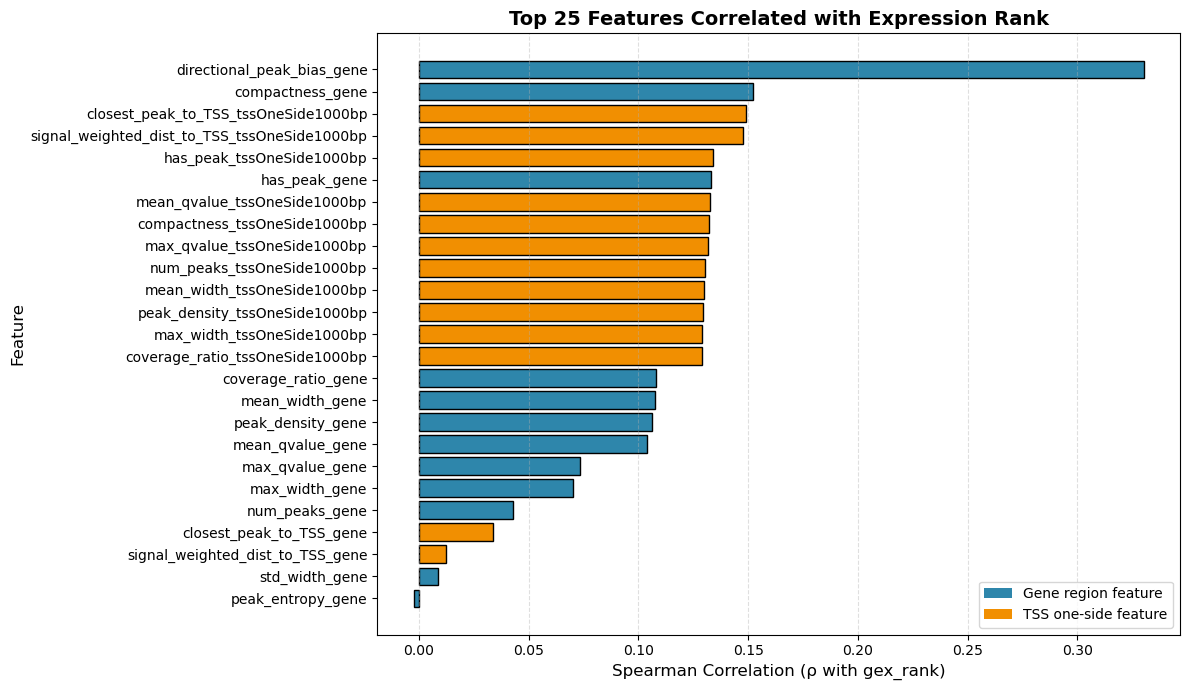

Top positively correlated features:
                                     feature      rho         pval region_type
                  directional_peak_bias_gene 0.330133 0.000000e+00        Gene
                            compactness_gene 0.152076 7.672585e-85        Gene
        closest_peak_to_TSS_tssOneSide1000bp 0.148850 2.546747e-81         TSS
signal_weighted_dist_to_TSS_tssOneSide1000bp 0.147589 5.762124e-80         TSS
                   has_peak_tssOneSide1000bp 0.134036 3.723532e-66         TSS
                               has_peak_gene 0.133192 2.430604e-65        Gene
                mean_qvalue_tssOneSide1000bp 0.132505 1.107099e-64         TSS
                compactness_tssOneSide1000bp 0.131988 3.451234e-64         TSS
                 max_qvalue_tssOneSide1000bp 0.131702 6.466686e-64         TSS
                  num_peaks_tssOneSide1000bp 0.130461 9.664517e-63         TSS

Top negatively correlated features:
                               feature       rho         p

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ============================================================
#                  Spearman correlation 可視化
# ============================================================
def plot_feature_correlations(df_out: pd.DataFrame, save_path=None, top_k=25):
    """
    對所有 feature 與 gex_rank 計算 Spearman correlation 並繪圖。
    會自動分 group 顯示 gene vs TSS feature。
    """
    corr_results = []

    # 取 numeric 欄位（排除 meta 與 gex/gex_rank）
    numeric_cols = [
        c for c in df_out.columns
        if c not in ["gene_name", "chr", "strand", "gex", "gene_start", "gene_end", "TSS_start", "TSS_end"]
        and np.issubdtype(df_out[c].dtype, np.number)
    ]

    # 計算 Spearman correlation
    for col in numeric_cols:
        r, p = spearmanr(df_out["gex"], df_out[col])
        corr_results.append({
            "feature": col,
            "rho": r,
            "pval": p,
            "region_type": "TSS" if "tss" in col.lower() else "Gene"
        })

    corr_df = pd.DataFrame(corr_results).dropna(subset=["rho"])
    corr_df = corr_df.sort_values("rho", ascending=False)

    # === 圖表設定 ===
    plt.figure(figsize=(12, 7))
    top_df = corr_df.head(top_k)
    colors = ["#2E86AB" if r == "Gene" else "#F18F01" for r in top_df["region_type"]]

    plt.barh(
        y=top_df["feature"][::-1],
        width=top_df["rho"][::-1],
        color=colors[::-1],
        edgecolor="black"
    )
    plt.xlabel("Spearman Correlation (ρ with gex_rank)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.title(f"Top {top_k} Features Correlated with Expression Rank", fontsize=14, weight="bold")
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()

    # 圖例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="#2E86AB", label="Gene region feature"),
        Patch(facecolor="#F18F01", label="TSS one-side feature")
    ]
    plt.legend(handles=legend_elements, loc="lower right")

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Correlation plot saved to: {save_path}")
    plt.show()

    return corr_df


# ============================================================
#                  執行並產圖
# ============================================================
# 確保 df_out 已包含 gex_rank
if "gex" not in df_out.columns:
    raise ValueError("⚠️ df_out must include 'gex_rank' column for correlation analysis.")

corr_df = plot_feature_correlations(
    df_out,
    top_k=25
)

# 預覽最高與最低相關的 feature
print("Top positively correlated features:")
print(corr_df.head(10).to_string(index=False))
print("\nTop negatively correlated features:")
print(corr_df.tail(10).to_string(index=False))


In [17]:
# ============================================================
#                  批次整合多 mark / 多 cell line
# ============================================================

def process_cellline(cell_name: str,
                     gene_file: str,
                     marks: List[str],
                     base_dir: str,
                     tss_window_bp: int = 1000,
                     output_dir: str = "../preprocessed_data/CAGE-merged/2. feature_annotated"):
    """
    對指定 cell line (如 X1) 的所有 histone marks 一次處理。
    輸出會是一個 TSV，包含所有 mark 的 features。
    """
    print(f"\n=== 🧬 Processing Cell Line: {cell_name} ===")
    print(f"Gene file: {gene_file}")

    # --- 載入基因 ---
    df_genes = pd.read_csv(
        gene_file, sep="\t",
        dtype={"gene_name": str, "chr": str, "gene_start": np.int64, "gene_end": np.int64,
               "TSS_start": np.int64, "TSS_end": np.int64, "strand": str}
    )

    # 確保 gene_name 唯一
    df_genes = df_genes.drop_duplicates(subset=["gene_name"]).reset_index(drop=True)

    # 初始化總輸出
    df_all = df_genes[["gene_name"]].copy()

    # === 逐 mark 執行 ===
    for mark in marks:
        bed_path = os.path.join(base_dir, f"{mark}-bed", f"{cell_name}.bed")

        if not os.path.exists(bed_path):
            print(f"⚠️ Skip {mark}: missing file {bed_path}")
            continue

        print(f"\n📖 Reading {mark} peaks → {bed_path}")
        df_peaks = pd.read_csv(
            bed_path, sep="\t", header=None,
            names=["chr", "start", "end", "name", "score", "strand",
                   "signal_value", "p_value", "q_value", "peak"],
            dtype={"chr": str, "start": np.int64, "end": np.int64,
                   "name": str, "score": float, "strand": str,
                   "signal_value": float, "p_value": float,
                   "q_value": float, "peak": np.int64}
        )

        # 前處理與一致化
        df_peaks = df_peaks[df_peaks["score"] > 0].copy()
        df_peaks["summit"] = df_peaks["start"] + df_peaks["peak"]
        df_peaks["width"] = df_peaks["end"] - df_peaks["start"]
        df_genes["chr"], df_peaks["chr"] = harmonize_chr_names(df_genes["chr"], df_peaks["chr"])
        df_peaks["signal_z"] = zscore_file(df_peaks["signal_value"])

        peaks_by_chr = {c: sub.reset_index(drop=True)
                        for c, sub in df_peaks.groupby("chr", sort=False)}

        # === 計算特徵 ===
        print(f"⚙️ Computing features for {mark} ...")
        feat_gene = compute_features(df_genes, peaks_by_chr, region="gene")
        feat_tss = compute_features(df_genes, peaks_by_chr, region="tss", tss_window_bp=tss_window_bp)

        # 後綴區分 mark 與區域
        feat_gene = feat_gene.rename(
            columns={c: f"{mark}_{c}_gene" for c in feat_gene.columns if c != "gene_name"})
        feat_tss = feat_tss.rename(
            columns={c: f"{mark}_{c}_tss" for c in feat_tss.columns if c != "gene_name"})

        # 合併
        df_all = (df_all
                  .merge(feat_gene, on="gene_name", how="left")
                  .merge(feat_tss, on="gene_name", how="left"))

    # === 儲存輸出 ===
    output_path = os.path.join(output_dir, f"{cell_name}_with_allMarks.tsv")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_all = df_all.fillna(0.0)
    df_all.to_csv(output_path, sep="\t", index=False)
    print(f"✅ Saved merged file: {output_path} ({df_all.shape[1]} columns)")
    return df_all


# ============================================================
#                  主批次執行
# ============================================================
if __name__ == "__main__":
    base = "/Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/"
    merged_base = "/Users/deweywang/Desktop/GitHub/Gene-expression-prediction/preprocessed_data/CAGE-merged/"
    
    marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
    cells = {
        "X1": os.path.join(merged_base, "1. original merged/X1_merged.tsv"),
        "X2": os.path.join(merged_base, "1. original merged/X2_merged.tsv"),
        "X3": os.path.join(base, "CAGE-train/CAGE-train/X3_test_info.tsv"),
    }

    output_dir = os.path.join(merged_base, "5. bed features")

    # 跑全部 cell line
    for cell, gene_file in cells.items():
        process_cellline(cell, gene_file, marks, base_dir=base, tss_window_bp=1000, output_dir=output_dir)



=== 🧬 Processing Cell Line: X1 ===
Gene file: /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/preprocessed_data/CAGE-merged/1. original merged/X1_merged.tsv

📖 Reading DNase peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/DNase-bed/X1.bed
⚙️ Computing features for DNase ...



📖 Reading H3K27ac peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K27ac-bed/X1.bed
⚙️ Computing features for H3K27ac ...



📖 Reading H3K4me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K4me3-bed/X1.bed
⚙️ Computing features for H3K4me3 ...



📖 Reading H3K27me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K27me3-bed/X1.bed
⚙️ Computing features for H3K27me3 ...



📖 Reading H3K36me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K36me3-bed/X1.bed
⚙️ Computing features for H3K36me3 ...



📖 Reading H3K4me1 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K4me1-bed/X1.bed
⚙️ Computing features for H3K4me1 ...



📖 Reading H3K9me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K9me3-bed/X1.bed
⚙️ Computing features for H3K9me3 ...


✅ Saved merged file: /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/preprocessed_data/CAGE-merged/5. bed features/X1_with_allMarks.tsv (281 columns)

=== 🧬 Processing Cell Line: X2 ===
Gene file: /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/preprocessed_data/CAGE-merged/1. original merged/X2_merged.tsv

📖 Reading DNase peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/DNase-bed/X2.bed
⚙️ Computing features for DNase ...



📖 Reading H3K27ac peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K27ac-bed/X2.bed
⚙️ Computing features for H3K27ac ...



📖 Reading H3K4me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K4me3-bed/X2.bed
⚙️ Computing features for H3K4me3 ...



📖 Reading H3K27me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K27me3-bed/X2.bed
⚙️ Computing features for H3K27me3 ...



📖 Reading H3K36me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K36me3-bed/X2.bed
⚙️ Computing features for H3K36me3 ...



📖 Reading H3K4me1 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K4me1-bed/X2.bed
⚙️ Computing features for H3K4me1 ...



📖 Reading H3K9me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K9me3-bed/X2.bed
⚙️ Computing features for H3K9me3 ...


✅ Saved merged file: /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/preprocessed_data/CAGE-merged/5. bed features/X2_with_allMarks.tsv (281 columns)

=== 🧬 Processing Cell Line: X3 ===
Gene file: /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/CAGE-train/CAGE-train/X3_test_info.tsv

📖 Reading DNase peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/DNase-bed/X3.bed
⚙️ Computing features for DNase ...



📖 Reading H3K27ac peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K27ac-bed/X3.bed
⚙️ Computing features for H3K27ac ...



📖 Reading H3K4me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K4me3-bed/X3.bed
⚙️ Computing features for H3K4me3 ...



📖 Reading H3K27me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K27me3-bed/X3.bed
⚙️ Computing features for H3K27me3 ...



📖 Reading H3K36me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K36me3-bed/X3.bed
⚙️ Computing features for H3K36me3 ...



📖 Reading H3K4me1 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K4me1-bed/X3.bed
⚙️ Computing features for H3K4me1 ...



📖 Reading H3K9me3 peaks → /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/ML4G_Project_1_Data/H3K9me3-bed/X3.bed
⚙️ Computing features for H3K9me3 ...


✅ Saved merged file: /Users/deweywang/Desktop/GitHub/Gene-expression-prediction/preprocessed_data/CAGE-merged/5. bed features/X3_with_allMarks.tsv (281 columns)


In [34]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, rankdata

def save_feature_summary(df, out_path):
    """
    生成每個特徵的統計摘要：
    - mean, std, min, max
    - missing rate
    - Spearman correlation with gex
    """
    print("🧮 Generating feature summary (Spearman correlation)...")

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if "gex" not in df.columns:
        raise ValueError("❌ 'gex' column not found in DataFrame!")
    if "gex" in numeric_cols:
        numeric_cols.remove("gex")

    summaries = []
    gex_vals = df["gex"].values

    for col in numeric_cols:
        vals = df[col].values
        mask = ~np.isnan(vals)

        # 基本統計
        mean_val = np.nanmean(vals)
        std_val = np.nanstd(vals)
        min_val = np.nanmin(vals)
        max_val = np.nanmax(vals)
        missing_rate = 1 - mask.mean()

        # Spearman correlation
        if np.sum(mask) > 3:
            try:
                corr, pval = spearmanr(vals[mask], gex_vals[mask])
            except Exception:
                corr, pval = np.nan, np.nan
        else:
            corr, pval = np.nan, np.nan

        summaries.append({
            "feature": col,
            "mean": mean_val,
            "std": std_val,
            "min": min_val,
            "max": max_val,
            "missing_rate": missing_rate,
            "spearman_corr_with_gex": corr,
            "corr_pvalue": pval,
        })

    summary_df = pd.DataFrame(summaries).sort_values(by="spearman_corr_with_gex", ascending=False)
    out_summary_path = out_path.replace(".tsv", "_feature_summary.tsv")
    summary_df.to_csv(out_summary_path, sep="\t", index=False, float_format="%.5f")

    print(f"✅ Feature summary saved → {out_summary_path}")
    print(f"📊 Total features analyzed: {len(summary_df)}")

    return summary_df

In [35]:
df = pd.read_csv("../preprocessed_data/CAGE-merged/X1_features.tsv", sep="\t")
summary_df = save_feature_summary(df, "../preprocessed_data/CAGE-merged/X1_features.tsv")

🧮 Generating feature summary (Spearman correlation)...
✅ Feature summary saved → ../preprocessed_data/CAGE-merged/X1_features_feature_summary.tsv
📊 Total features analyzed: 460


In [ ]:
我現在要來寫給lgbm訓練
我要讀取這個file:
來當training data: preprocessed_data/CAGE-merged/X1_features.tsv
然後preprocessed_data/CAGE-merged/X1_features.tsv來當valdata

我要用的column是除了gene_name	chr	gene_start	gene_end	TSS_start	TSS_end	strand	gex以外的所有columns，並且預測的目標是gex，並且幫我把gex改成rank based，並且這個r我想要

In [36]:
df = pd.read_csv("../preprocessed_data/CAGE-merged/X2_features.tsv", sep="\t")
summary_df = save_feature_summary(df, "../preprocessed_data/CAGE-merged/X2_features.tsv")

🧮 Generating feature summary (Spearman correlation)...
✅ Feature summary saved → ../preprocessed_data/CAGE-merged/X2_features_feature_summary.tsv
📊 Total features analyzed: 460
